открываем сверху вкладку Runtime -> change Runtime type: <br>
Runtime type: Python3<br>
Hardware accelerator: GPU

In [1]:
!git clone https://github.com/chamecall/scripts.git
%cd scripts/train_detectron
!ls
!unzip data.zip -d data

Cloning into 'scripts'...
remote: Enumerating objects: 535, done.
remote: Counting objects: 100% (535/535), done.
remote: Compressing objects: 100% (432/432), done.
remote: Total 535 (delta 96), reused 534 (delta 95), pack-reused 0
Receiving objects: 100% (535/535), 16.05 MiB | 36.36 MiB/s, done.
Resolving deltas: 100% (96/96), done.
/content/scripts/train_detectron
data.zip  detectron2  pascal_voc_xml2json.py
Archive:  data.zip
   creating: data/annotations/
   creating: data/annotations/train/
  inflating: data/annotations/train/1_069.xml  
  inflating: data/annotations/train/1_071.xml  
  inflating: data/annotations/train/1_072.xml  
  inflating: data/annotations/train/1_073.xml  
  inflating: data/annotations/train/1_074.xml  
   creating: data/annotations/val/
  inflating: data/annotations/val/1_068.xml  
  inflating: data/annotations/val/1_070.xml  
   creating: data/images/
   creating: data/images/train/
  inflating: data/images/train/1_069.png  
  inflating: data/images/train/

Распаковываем архив<br>
# Содержимое архива:
*   detecton2/ - фреймворк детектирования объектов, можно забрать [здесь](https://github.com/facebookresearch/detectron2.git), здесь нам нужны только конфиги
*   images/ - каталог с изображениями (train - для обучения, val - для валидации)
*   annotations/ - каталог с файлами разметки (train - для обучения, val - для валидацииодин файл на одно изображение)
*   pascal_voc_xml2json.py - скрипт конвертирования файлов разметки из xml файлов(Pascal VOC) в json формат(COCO)

# Данный шаг объясняет процесс создания каталогов images/ и annotations/

скачиваем labelimg для разметки изображений [здесь](https://tzutalin.github.io/labelImg/)<br>

детекции по каждому классу нужно разделить на две части в отношении 90%/10% на тренировочные данные и валидационные (images/train и images/val)<br>

далее размечаем изображения каждого каталога (train и val) в labelimg:<br>
*   Open Dir - указываем каталог, в котором хранятся изображения(image/train или images/val)
*   Change Save Dir - указываем каталог, где будем хранить размеченные xml файлы (annotations/train или annotations/val)

у нам всего 7 изображений, на каждом из которых изображено два класса (cat и dog). 5 изображений мы используем для обучения (по 5 сэмплов каждого класса соответственно) и 2 для валидации (по 2 сэмпла каждого класса соответственно)



Cтавим detectron

In [2]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
     |████████████████████████████████| 6.2MB 8.5MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.dev200325-cp36-none-any.whl size=38930 sha256=461f61ed6c046b797218dadb54c9b444f283cf57cb9fac5b592c584e9e5c62e6
  Stored in directory: /root/.cache/pip/wheels/58/4f/d1/6b0ada294145df5fe73092d9849d27be5b5b720fd8cfdd1b98
Successfully built fvcore
ERROR: fvcore 0.1.dev200325 has requirement pyyaml>=5.1, but you'll have pyyaml 3.13 which is incompatible.


конвертируем размеченные xml файлы в json формат..<br>
на выходе получаем 2 json файла:
*   для обучения
*   для валидации

In [3]:
!python pascal_voc_xml2json.py -annot data/annotations/train
!python pascal_voc_xml2json.py -annot data/annotations/val

!ls *.json

add image with 1_071.png and {'width': 1366, 'height': 768, 'depth': 3}
add annotation with cat,20180000001,1,[198, 165, 277, 152]
add annotation with dog,20180000001,2,[855, 128, 274, 171]
add image with 1_073.png and {'width': 1366, 'height': 768, 'depth': 3}
add annotation with cat,20180000002,1,[667, 293, 166, 120]
add annotation with dog,20180000002,2,[461, 275, 132, 114]
add image with 1_072.png and {'width': 1366, 'height': 768, 'depth': 3}
add annotation with dog,20180000003,2,[912, 235, 241, 217]
add annotation with cat,20180000003,1,[279, 178, 269, 180]
add image with 1_069.png and {'width': 1366, 'height': 768, 'depth': 3}
add annotation with cat,20180000004,1,[254, 231, 318, 242]
add annotation with dog,20180000004,2,[814, 130, 270, 224]
add image with 1_074.png and {'width': 1366, 'height': 768, 'depth': 3}
add annotation with dog,20180000005,2,[462, 135, 143, 99]
add annotation with cat,20180000005,1,[655, 106, 103, 76]
add image with 1_068.png and {'width': 1366, 'height

In [0]:
import detectron2
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import os
import cv2
import random
from google.colab.patches import cv2_imshow
from detectron2.utils.visualizer import Visualizer

регистрируем датасеты

In [6]:
register_coco_instances('train_set', {}, './train.json', 'data/images/train')
register_coco_instances('val_set', {}, './val.json', 'data/images/val')


AssertionError: ignored

получаем тренировочные метаданные с нашими классами и наш тренировочный датасет, сконвертированный в формат detectron-a (по словарю на изображение)

In [7]:
train_metadata_catalog = MetadataCatalog.get('train_set')
train_dataset_catalog = DatasetCatalog.get('train_set')
train_metadata_catalog.thing_classes

['cat', 'dog']

визуализируем случайные размеченные выборки из тренировочного набора

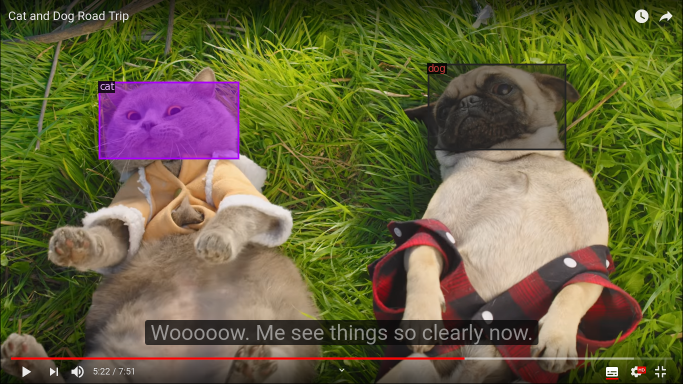

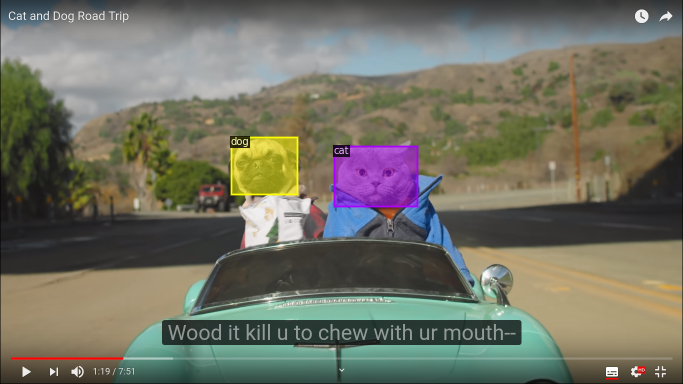

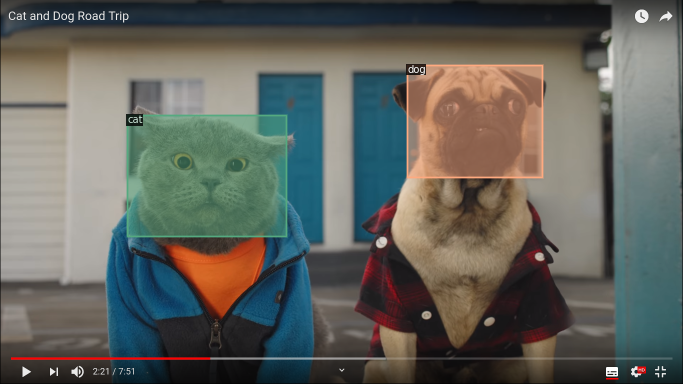

In [8]:
samples_no = 3
for d in random.sample(train_dataset_catalog, samples_no):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata_catalog, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])


#настройка конфигурации и обучение

показателем успешного обучения является уменьшающееся значение ошибки ("total_loss")

In [9]:
cfg = get_cfg()
# конфиг сети
cfg.merge_from_file('./detectron2/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml')
# указываем наши зарегистрированные датасеты
cfg.DATASETS.TRAIN = ('train_set',)
cfg.DATASETS.TEST = ('val_set',)
cfg.DATALOADER.NUM_WORKERS = 2
# инициализируем сеть предтренированными весами (обучение происходит чуть быстрее, чем на случайно инициализированных)
cfg.MODEL.WEIGHTS = 'detectron2://COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl'
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
# количество эпох (итераций) прохождения по всем изображениям
cfg.SOLVER.MAX_ITER = (250)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (128)
# количество категорий, у нас две [cat, dog]
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

# создаем каталог для обученных весов
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
# запускаем тренировку
trainer.train()

[04/02 19:15:25 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:05, 48.6MB/s]                           
'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (3, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (3,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (8, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (8,) in the model! Skipped.


[04/02 19:15:38 d2.engine.train_loop]: Starting training from iteration 0
[04/02 19:15:48 d2.utils.events]:  eta: 0:01:44  iter: 19  total_loss: 1.610  loss_cls: 0.777  loss_box_reg: 0.819  loss_rpn_cls: 0.008  loss_rpn_loc: 0.012  time: 0.4471  data_time: 0.0237  lr: 0.000400  max_mem: 3661M
[04/02 19:15:57 d2.utils.events]:  eta: 0:01:36  iter: 39  total_loss: 1.217  loss_cls: 0.309  loss_box_reg: 0.900  loss_rpn_cls: 0.003  loss_rpn_loc: 0.007  time: 0.4468  data_time: 0.0064  lr: 0.000799  max_mem: 3661M
[04/02 19:16:06 d2.utils.events]:  eta: 0:01:26  iter: 59  total_loss: 0.549  loss_cls: 0.073  loss_box_reg: 0.470  loss_rpn_cls: 0.001  loss_rpn_loc: 0.006  time: 0.4454  data_time: 0.0054  lr: 0.001199  max_mem: 3661M
[04/02 19:16:15 d2.utils.events]:  eta: 0:01:17  iter: 79  total_loss: 0.323  loss_cls: 0.069  loss_box_reg: 0.252  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  time: 0.4460  data_time: 0.0056  lr: 0.001598  max_mem: 3661M
[04/02 19:16:24 d2.utils.events]:  eta: 0:01:0

в текущей директории был создан каталог output, в нем находятся обученные веса (model_final.pth)<br>
получаем наши классы;<br>
инициализируем модель обученными весами;<br>
получаем валидационный датасет

In [10]:
from detectron2.data.catalog import Metadata

metadata = Metadata()
metadata.set(thing_classes = train_metadata_catalog.thing_classes)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  
predictor = DefaultPredictor(cfg)
val_dataset_catalog = DatasetCatalog.get('val_set')

[04/02 19:18:02 d2.data.datasets.coco]: Loaded 2 images in COCO format from ./val.json


на валидационном датасете(из 2 изображений) пропускаем сеть с обученными весами и визуализируем результаты 

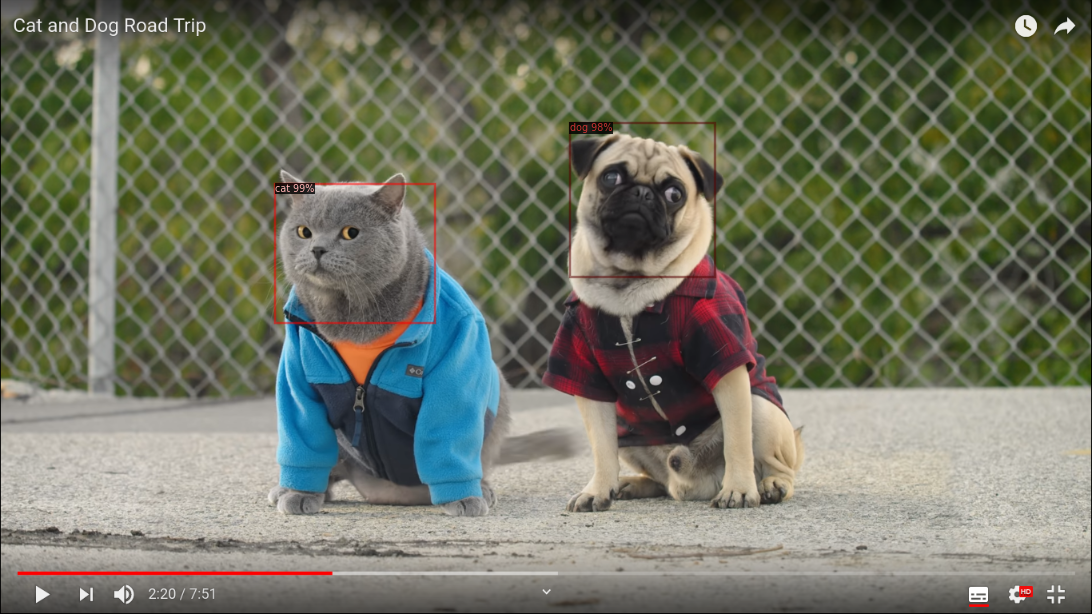

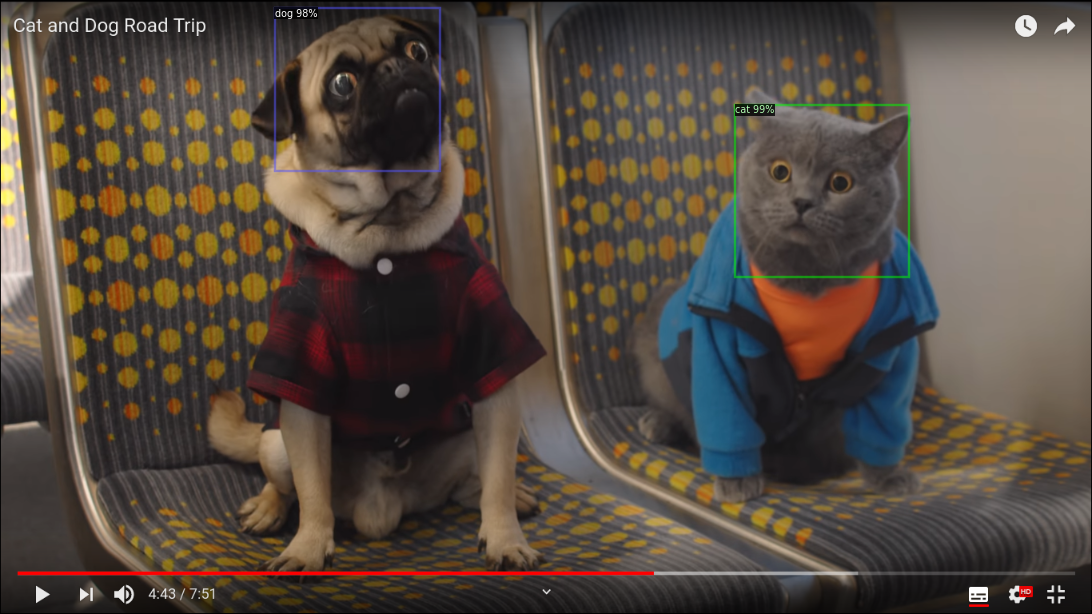

In [11]:

for d in random.sample(val_dataset_catalog, 2):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata, 
                   scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])